In [1]:
import sys
import ssl
import urllib.request
from io import StringIO

from copy import deepcopy
import os
from os import getcwd
from os.path import dirname, join
from sklearn.neighbors import KNeighborsRegressor
from scipy.optimize import minimize, basinhopping


import datetime
from sklearn import preprocessing



import csv
import json

# Load Json File
# Load the arguments
with open('arguments.json', 'r') as fid:
    arguments = json.load(fid)




import matplotlib.pyplot as plt
import numpy as np
import scipy 
import pandas as pd
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

SRC_DIR = '../../mammal/MAMMAL' # relative path to MAMMAL library 
sys.path.append(SRC_DIR)
BASE_DIR = getcwd() # get current directory with files
DATA_DIR = join(BASE_DIR, arguments['data_dir'])
TEST_DIR = DATA_DIR

import Diurnal
from Parse import parseIM as pi
from Utils import ProcessingUtils as pu
from Utils import Filters as filt


%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)#

# Load INTERMAGNET Data

/home/antuser/anaconda3/envs/envp39/lib/python3.9/site-packages/pandas-1.3.4-py3.9-linux-x86_64.egg/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Loaded bou20230731qmin.min
Loaded frd20230731qmin.min
Loaded frd20230726qmin.min
Loaded bou20230726qmin.min
Loaded frd20230727qmin.min
Loaded bou20230727qmin.min
Loaded frd20230801qmin.min
Loaded bou20230801qmin.min
Loaded frd20230802qmin.min
Loaded bou20230802qmin.min
Loaded bou20230725qmin.min
Loaded frd20230725qmin.min
Loaded frd20230730qmin.min
Loaded bou20230730qmin.min
Loaded bou20230729qmin.min
Loaded frd20230729qmin.min
Loaded bou20230724qmin.min
Loaded frd20230724qmin.min
Loaded bou20230728qmin.min
Loaded frd20230728qmin.min
Loaded bou20230808qmin.min
Loaded frd20230808qmin.min
Loaded frd20230804qmin.min
Loaded bou20230804qmin.min
Loaded bou20230807qmin.min
Loaded frd20230807qmin.min
Loaded bou20230809qmin.min
Loaded frd20230809qmin.min
Loaded bou20230803qmin.min
Loaded frd20230803qmin.min
Loaded frd20230806qmin.min
Loaded bou20230806qmin.min
Loaded bou20230805qmin.min
Loaded frd20230805qmin.min


100%|████████████████████████████████████████| 121/121 [00:00<00:00, 132.81it/s]


            DATE     TIME  DOY        X       Y        Z         F  \
0     2023-07-24      0.0  205  20509.4  2889.4  47071.1  51437.18   
1     2023-07-24     60.0  205  20509.4  2889.4  47071.1  51437.18   
2     2023-07-24    120.0  205  20509.1  2889.7  47071.1  51436.98   
3     2023-07-24    180.0  205  20508.9  2889.7  47071.2  51436.99   
4     2023-07-24    240.0  205  20508.4  2889.9  47071.1  51436.81   
...          ...      ...  ...      ...     ...      ...       ...   
1435  2023-08-09  86100.0  221  20502.5  2885.1  47048.6  51413.99   
1436  2023-08-09  86160.0  221  20502.4  2885.3  47048.7  51414.16   
1437  2023-08-09  86220.0  221  20502.8  2885.3  47048.8  51414.31   
1438  2023-08-09  86280.0  221  20503.2  2885.3  47048.9  51414.56   
1439  2023-08-09  86340.0  221  20503.4  2885.2  47049.0  51414.72   

                datetime     epoch_sec     LAT     LONG     ALT        IGRF_X  \
0    2023-07-24 00:00:00  1.690157e+09  40.137 -105.237  1682.0  20528.786997 

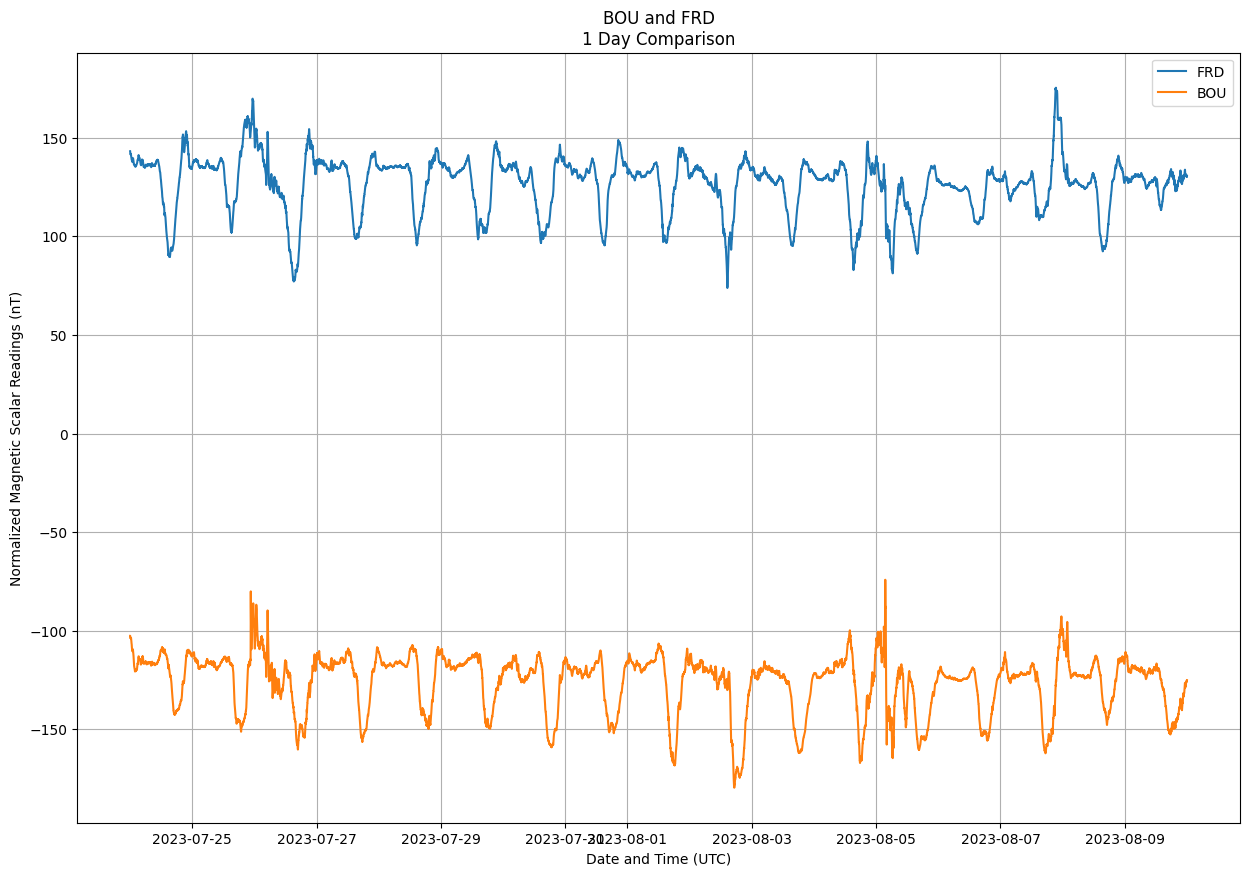

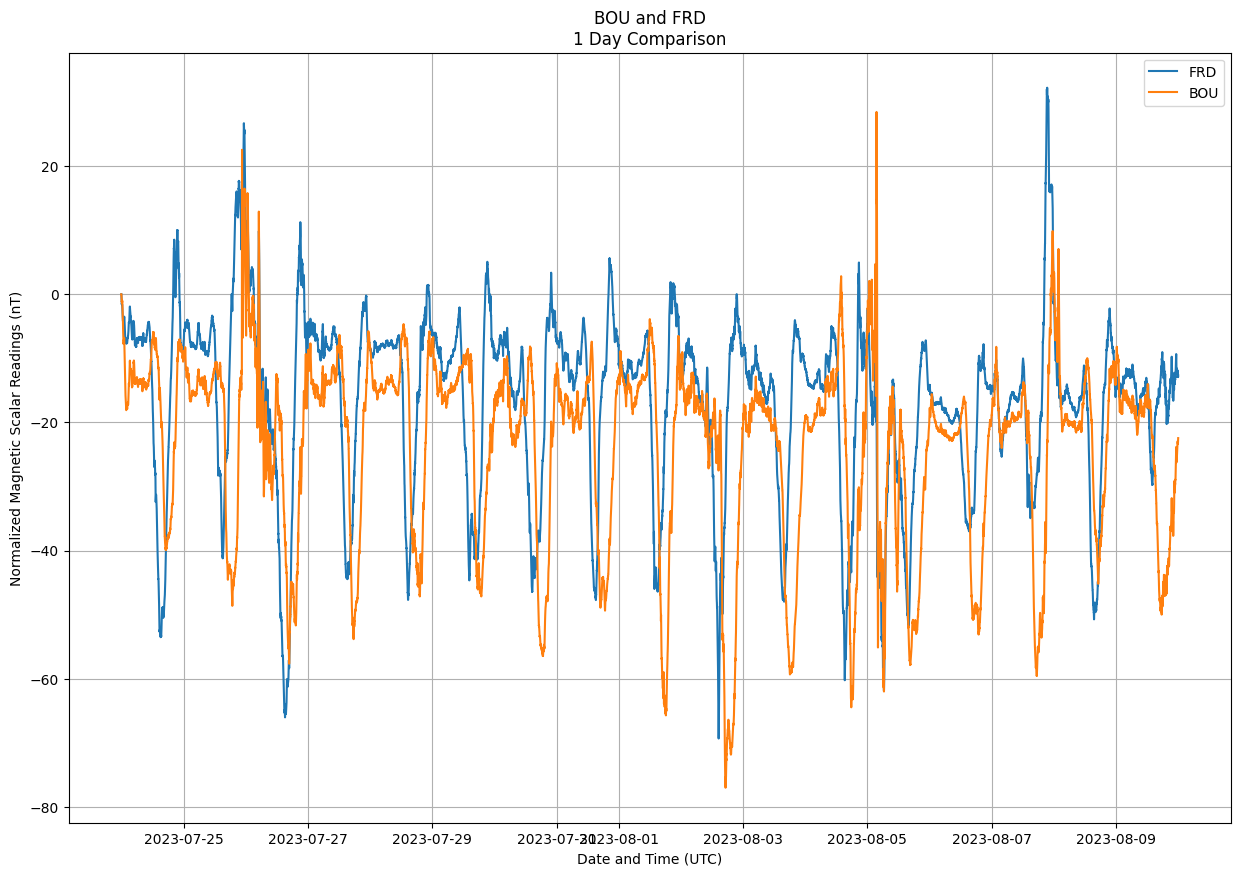

In [2]:
df_dict = pi.loadInterMagData(TEST_DIR, fast_mode = False, second = False)

from_name = arguments['from_data'] # data from 'extended' station
to_name   = arguments['to_data'] # data at location to estimate

from_df = df_dict[from_name]
to_df   = df_dict[to_name]


to_df = pu.reject_outliers(to_df,
                           window_size=200,
                           std_lim=3)

print(from_df)
to_IGRF_f   = np.array(to_df.IGRF_F)[0]
from_IGRF_f = np.array(from_df.IGRF_F)[0]

to_f   = np.array(to_df.F)
from_f = np.array(from_df.F)
    
to_f_no_core   = np.array(to_df.F) - to_IGRF_f
from_f_no_core = np.array(from_df.F) - from_IGRF_f
    
to_t   = np.array(to_df.epoch_sec)
from_t = np.array(from_df.epoch_sec)

plt.figure()
plt.title(from_name + ' and ' + to_name + '\n1 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime, from_f_no_core, label=from_name)
plt.legend()
plt.grid()
    
plt.figure()
plt.title(from_name + ' and ' + to_name + '\n1 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core - to_f_no_core[0], label=to_name)
plt.plot(from_df.datetime, from_f_no_core - from_f_no_core[0], label=from_name)
plt.legend()
plt.grid()

# print('RMSE:', pu.rmse(to_f_no_core, from_f_no_core[:len(to_f)])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers
# print('RMSE:', pu.rmse(to_f_no_core - to_f_no_core[0], from_f_no_core[:len(to_f)] - from_f_no_core[0])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers

# Simple Longitude Normalization

RMSE: 252.76745872048264


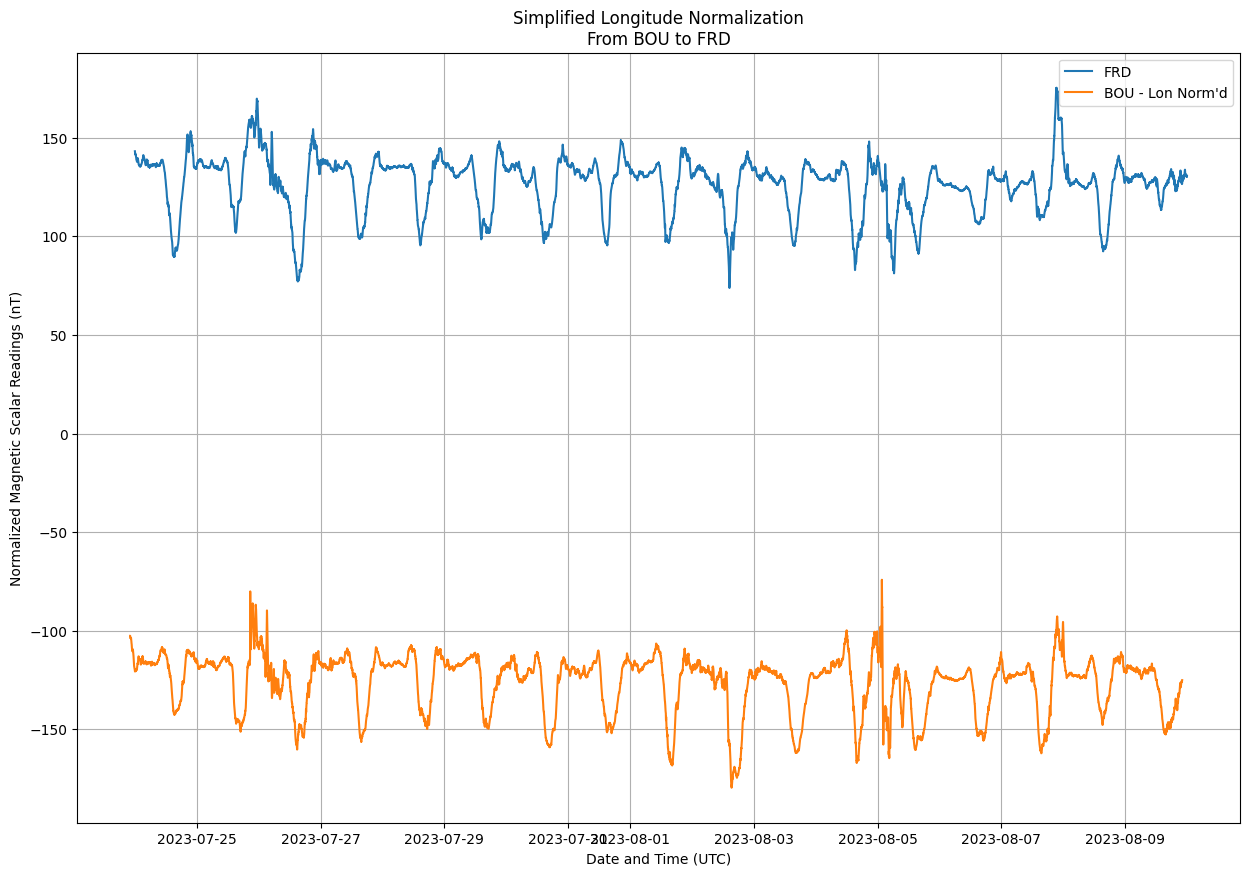

In [3]:
lon_diff     = from_df.LONG.mean() - to_df.LONG.mean()
lon_t_offset = pd.Timedelta(seconds=lon_diff / (Diurnal.E_ROT_DEG_S))
bou_shift_t  = from_df.epoch_sec + lon_t_offset.total_seconds()

plt.figure()
plt.title('Simplified Longitude Normalization\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime + lon_t_offset, from_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

interp_lpf = interpolate.interp1d(bou_shift_t, from_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= bou_shift_t.min(), to_t <= bou_shift_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

bou_shift_interp = interp_lpf(interp_t)

print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
                       bou_shift_interp))

# Frequency-Based Longitude Normalization

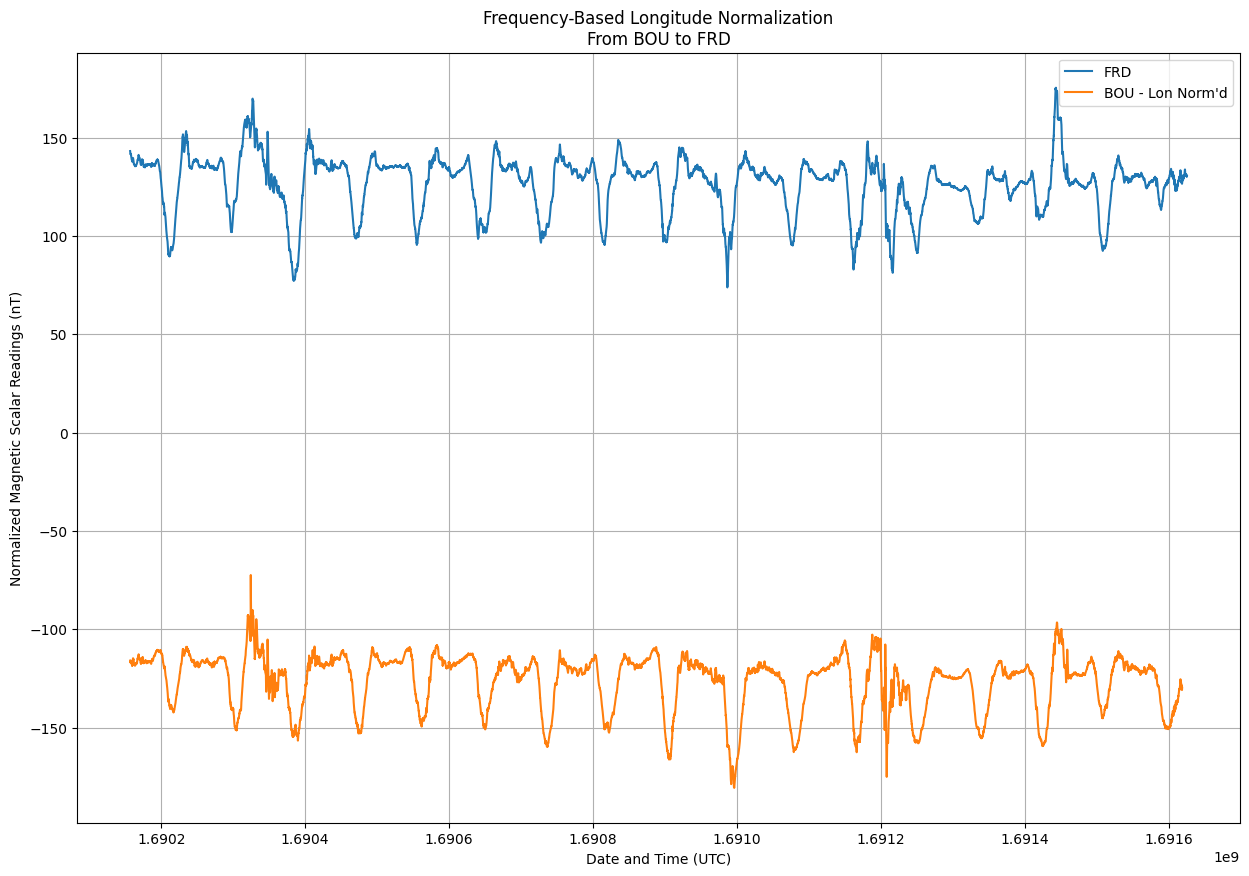

In [4]:
from_combined_t, from_combined_f, _, _ , _ = Diurnal.longitude_norm(from_df, to_df.LONG.mean(), second = False)
from_combined_f_no_core = from_combined_f - from_IGRF_f

plt.figure()
plt.title('Frequency-Based Longitude Normalization\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec, to_f_no_core, label=to_name)
plt.plot(from_combined_t, from_combined_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

# print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
#                        from_combined_f_no_core[:len(to_f_no_core[interp_mask])]))

# Interpolation

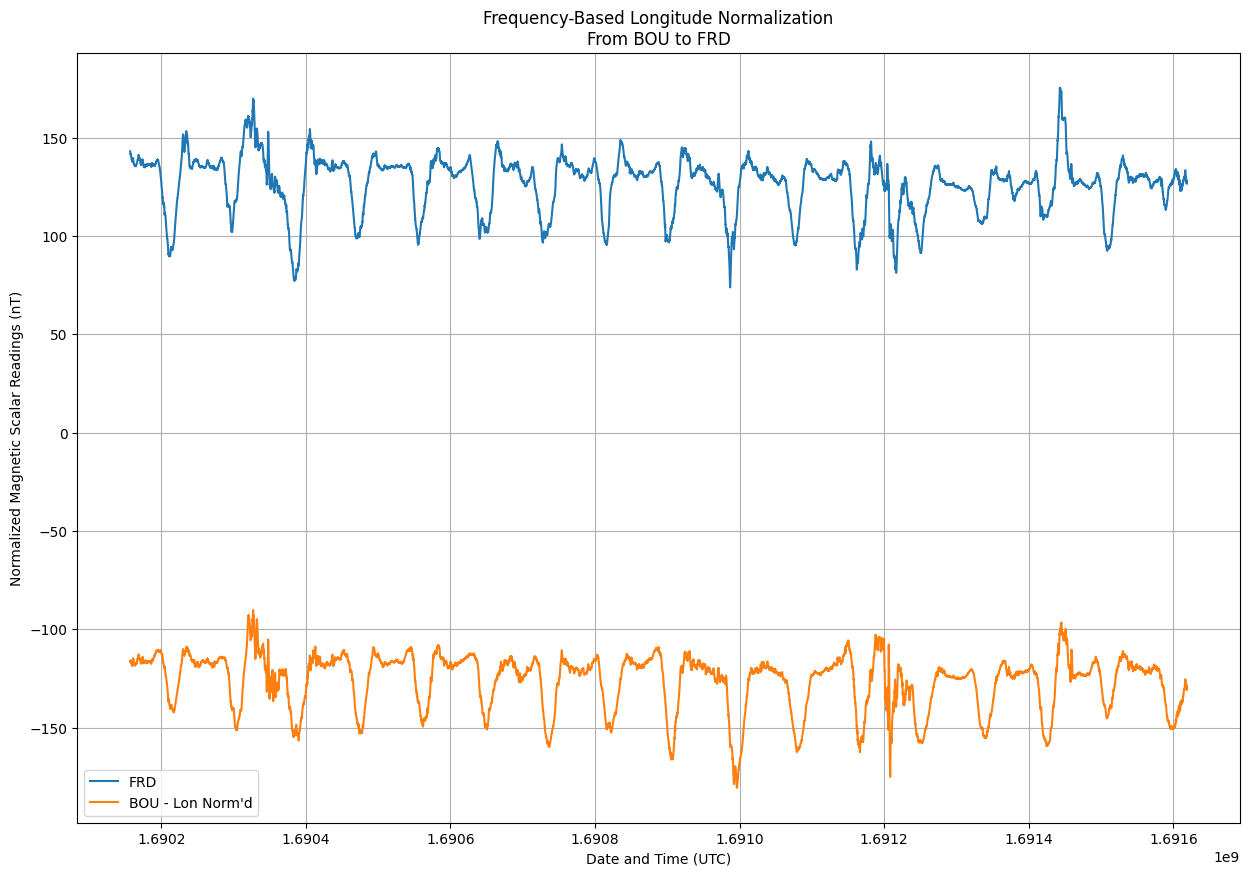

In [5]:
# Linear Regression Method    
interp_combined = interpolate.interp1d(from_combined_t, from_combined_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= from_combined_t.min(), to_t <= from_combined_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

from_combined_interp = interp_combined(interp_t)


plt.figure()
plt.title('Frequency-Based Longitude Normalization\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(interp_t, to_f_no_core[interp_mask], label=to_name)
plt.plot(interp_t, from_combined_interp, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()



# Remove Signal Means and Plot Autocorrelation

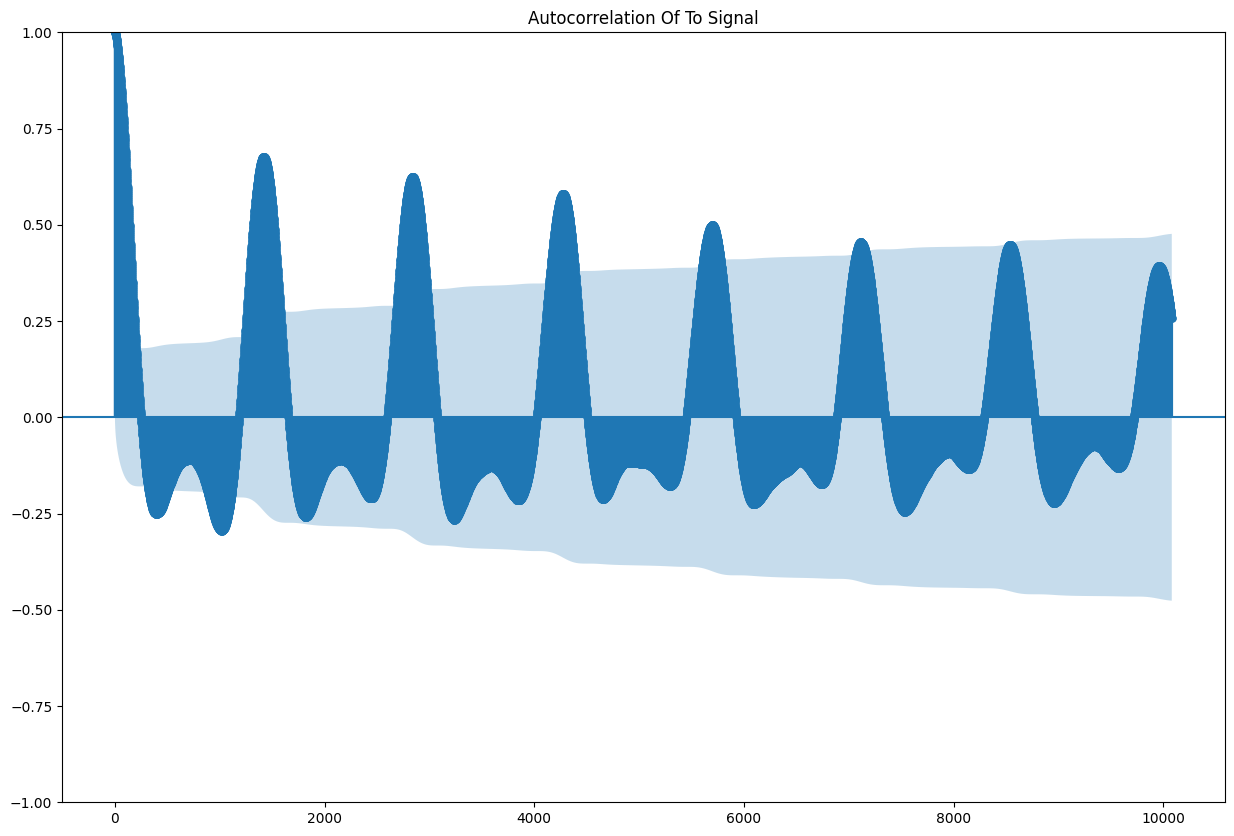

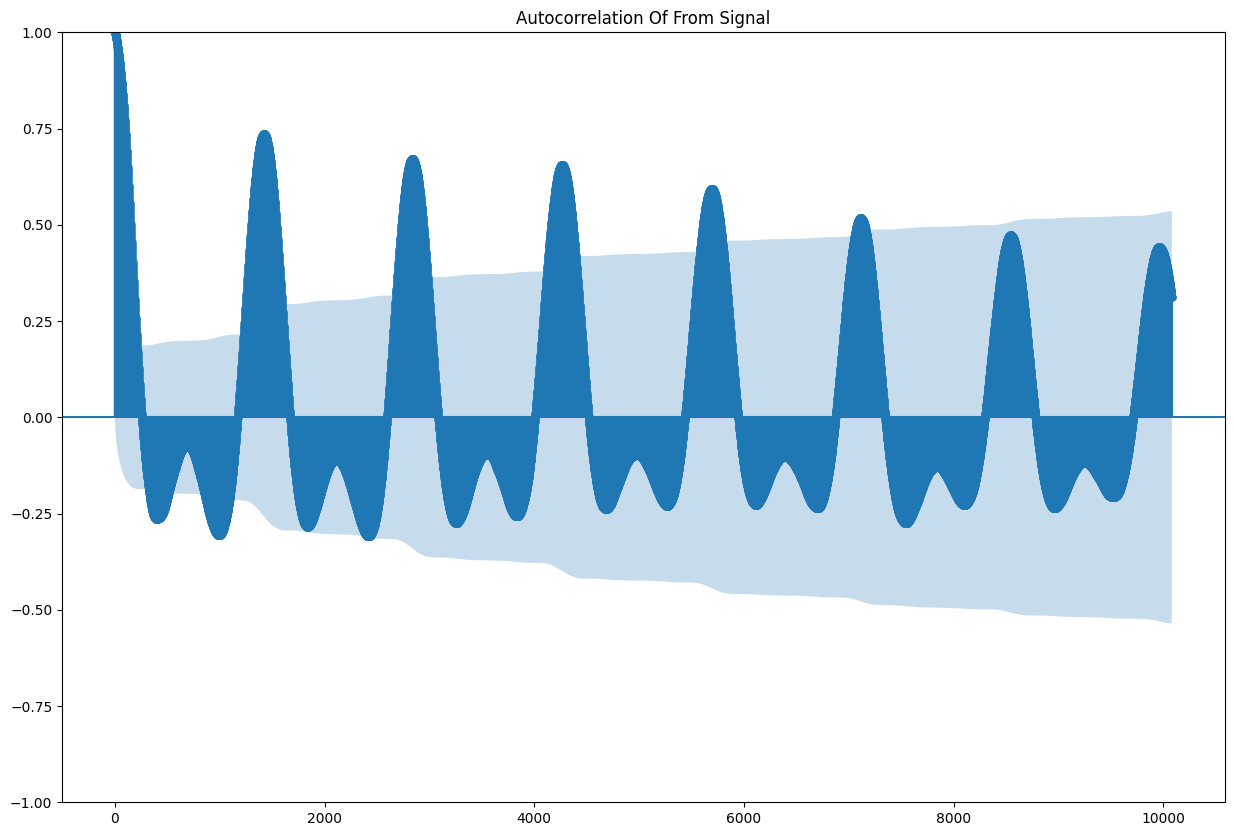

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_std=False)
# common time stamp with interp_t
# Mean Removed For Both signals
to_signal = scaler.fit_transform(to_f_no_core[interp_mask].reshape(-1, 1))
from_signal = scaler.fit_transform(from_combined_interp.reshape(-1, 1))

#print(np.mean(to_signal),np.mean(from_signal))

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(to_signal, lags=7*24*60, title= 'Autocorrelation Of To Signal')
plt.show()

plot_acf(from_signal, lags=7*24*60, title= 'Autocorrelation Of From Signal')
plt.show()

# Signal Correlation

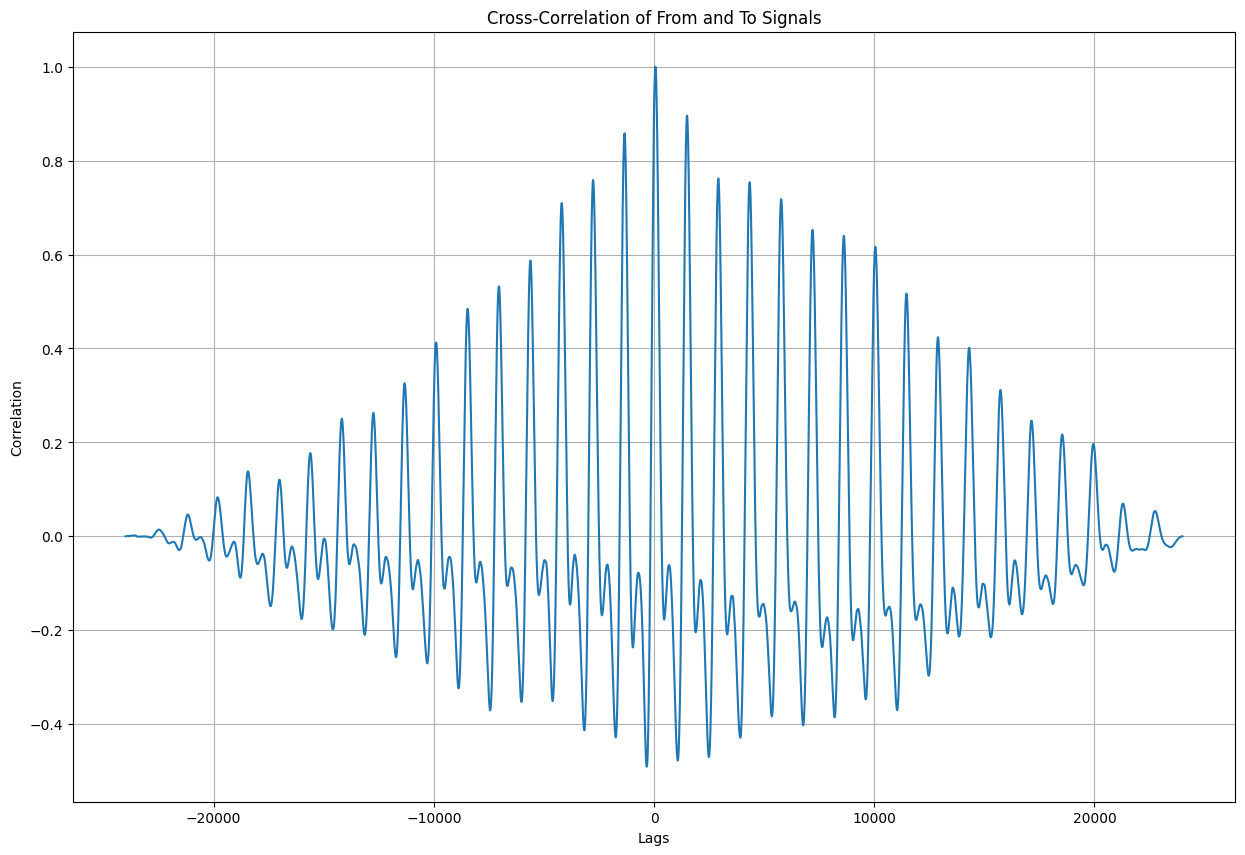

In [7]:
from scipy import signal

corr = signal.correlate(from_signal, to_signal)
lags = signal.correlation_lags(len(from_signal), len(to_signal))

corr /= np.max(corr) # Is this needed

plt.figure()
plt.plot(lags, corr)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Cross-Correlation of From and To Signals')
plt.grid()

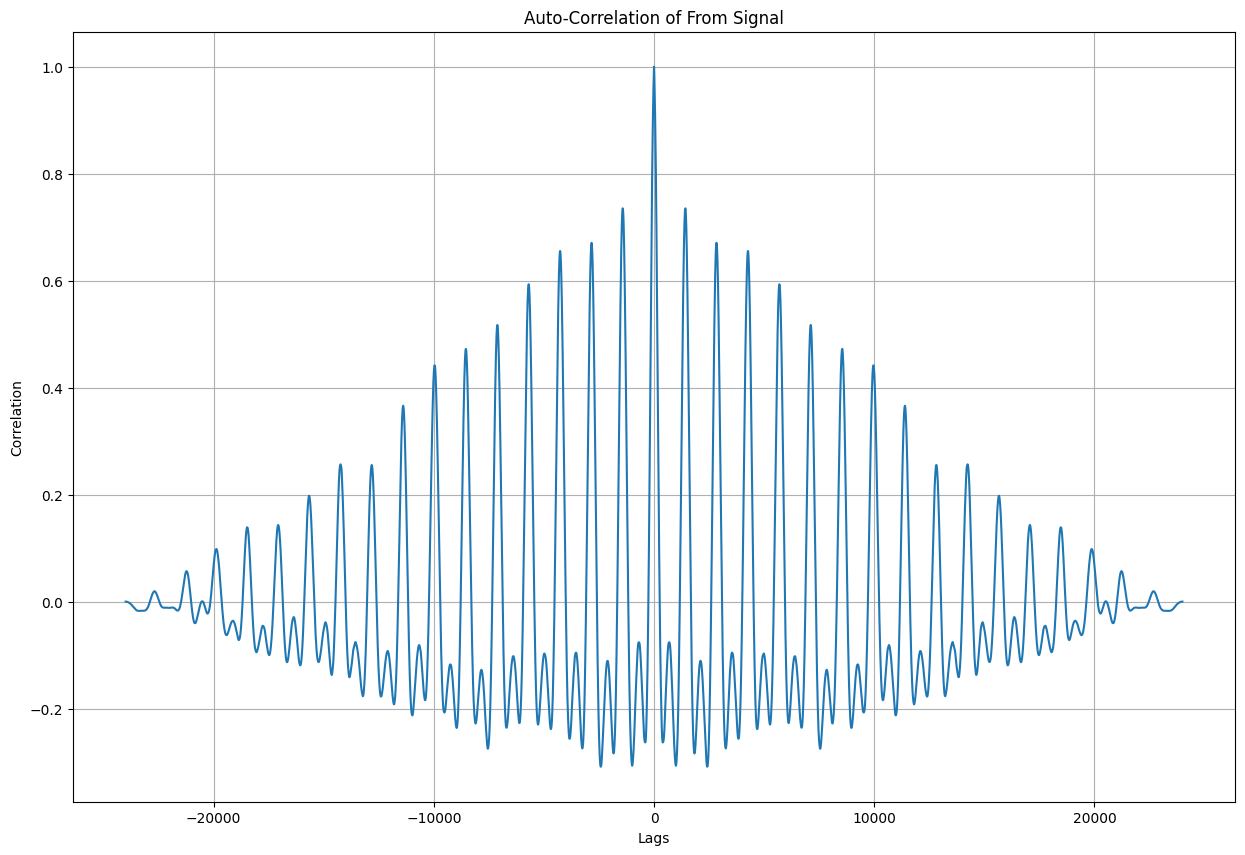

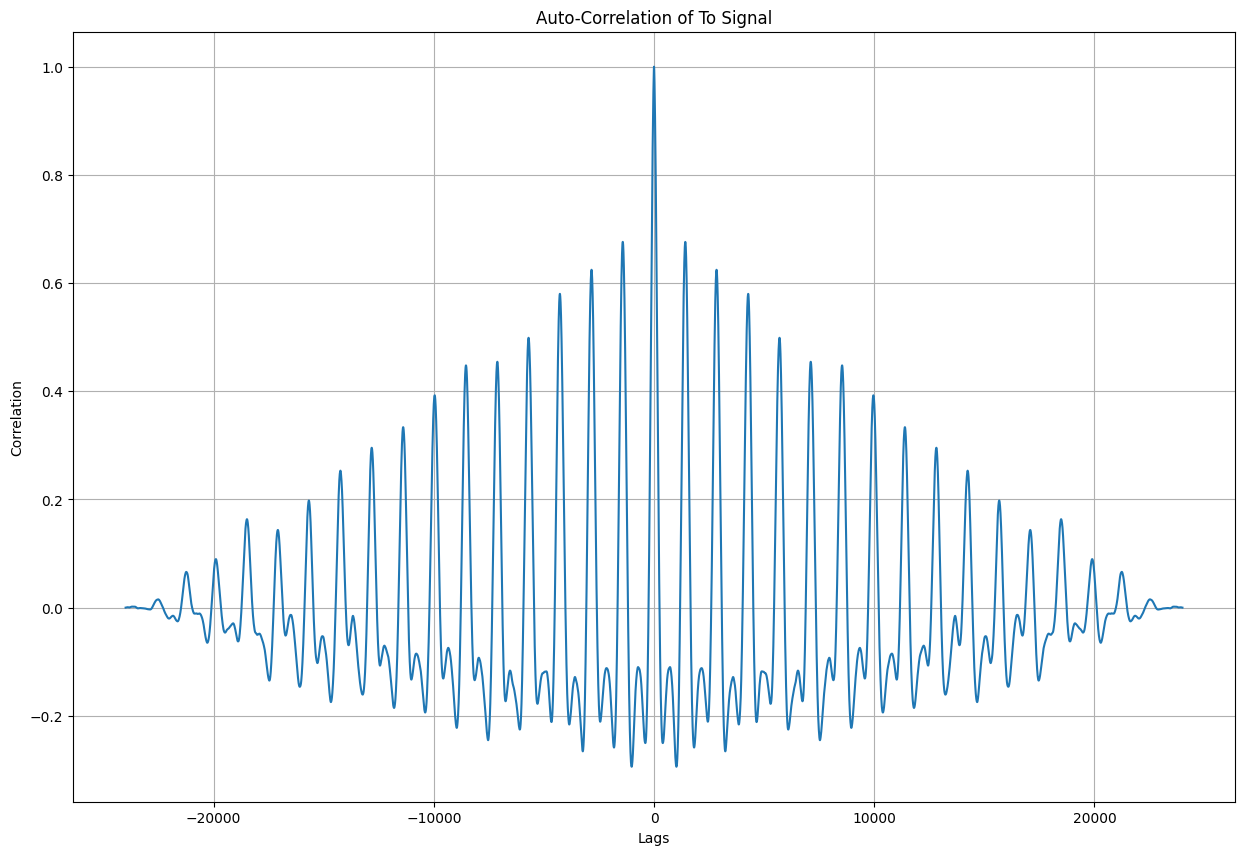

In [8]:
from scipy import signal

corr_from = signal.correlate(from_signal, from_signal)
lags_from = signal.correlation_lags(len(from_signal), len(from_signal))

corr_from /= np.max(corr_from) # Is this needed

plt.figure()
plt.plot(lags_from, corr_from)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Auto-Correlation of From Signal')
plt.grid()


from scipy import signal

corr_to = signal.correlate(to_signal, to_signal)
lags_to = signal.correlation_lags(len(to_signal), len(to_signal))

corr_to /= np.max(corr_to) # Is this needed

plt.figure()
plt.plot(lags_to, corr_to)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Auto-Correlation of To Signal')
plt.grid()

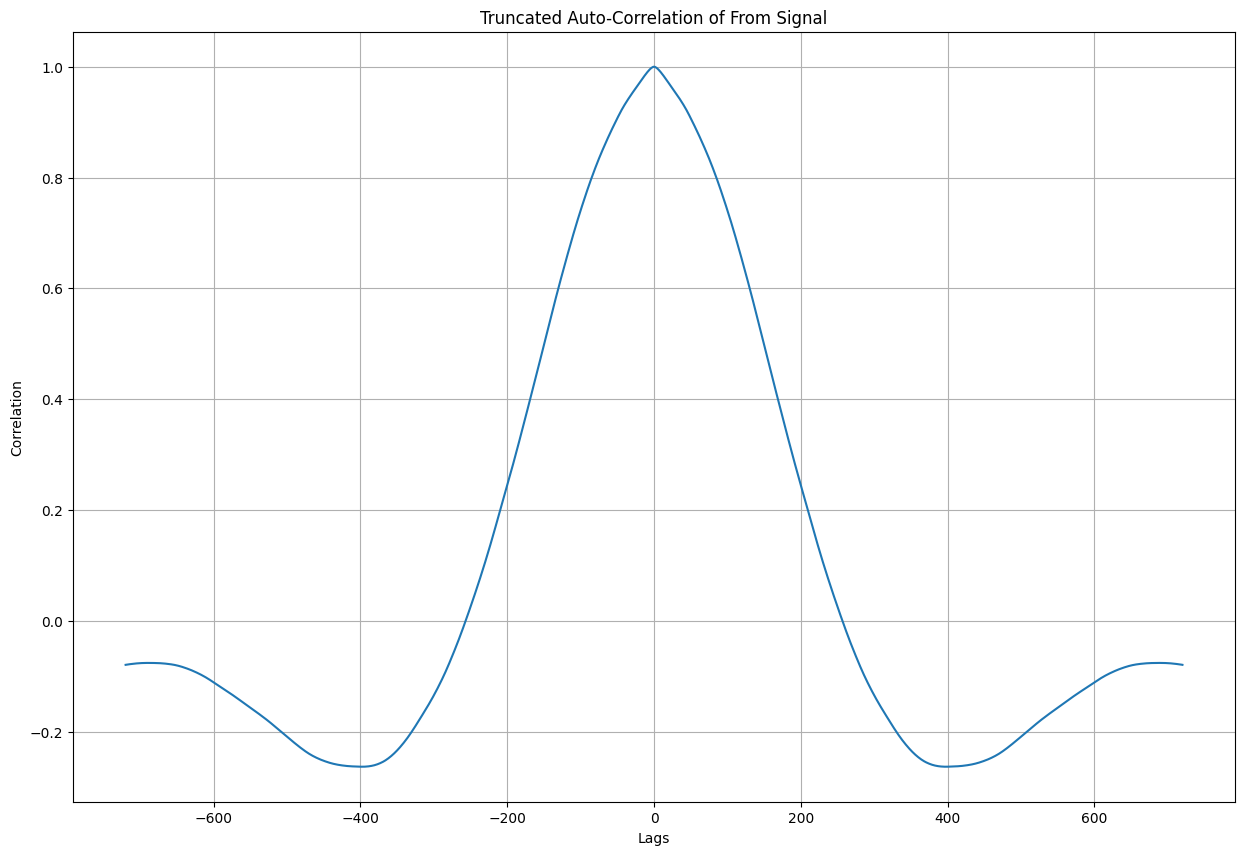

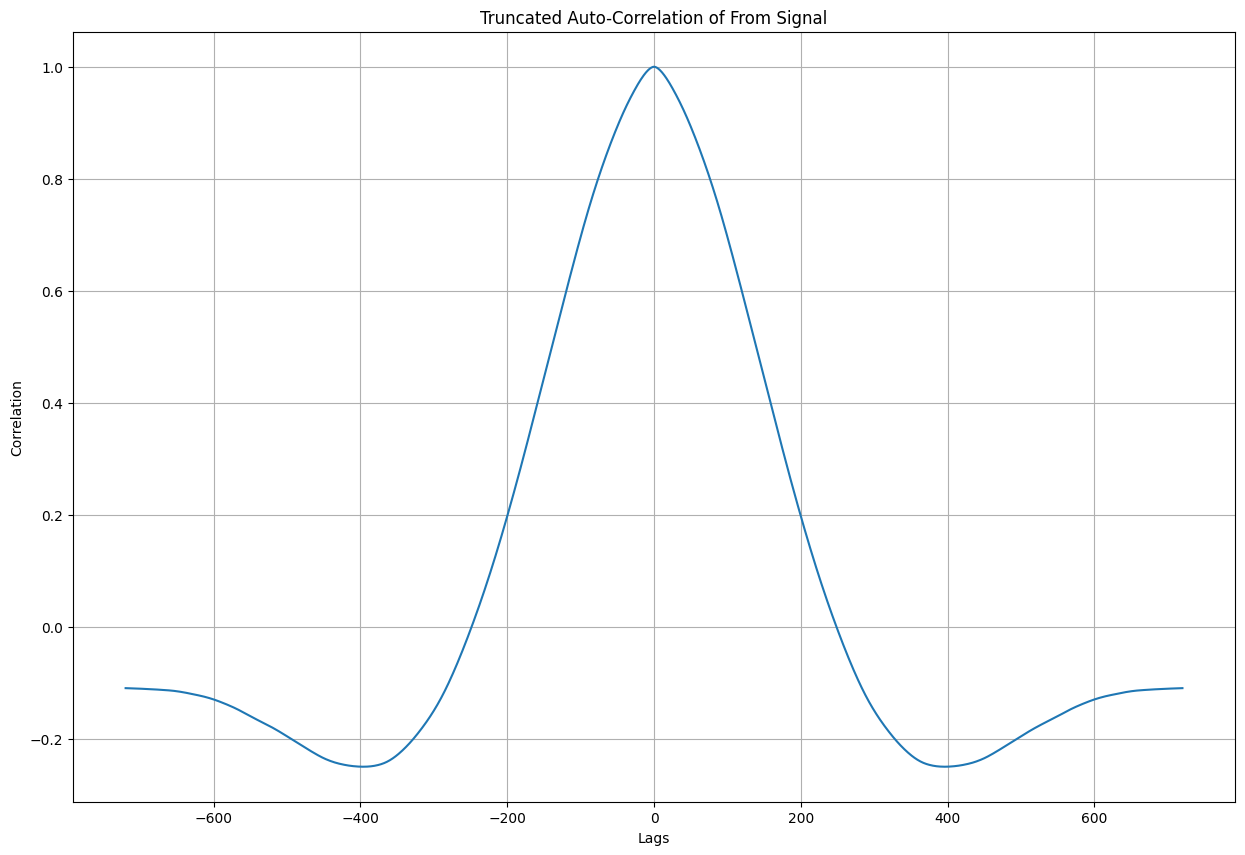

In [96]:
hours = 12

truncate = [(lag>=-hours*60) and (lag<=hours*60) for lag in lags_from]

truncate_great_zero = [(lag>=-hours*60) and (lag<=hours*60) for lag in lags_from]

corr_from_trunc = corr_from[truncate]
lags_from_trunc = lags_from[truncate]

plt.figure()
plt.plot(lags_from_trunc, corr_from_trunc)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Truncated Auto-Correlation of From Signal')
plt.grid()

corr_to_trunc = corr_to[truncate]
lags_to_trunc = lags_to[truncate]

plt.figure()
plt.plot(lags_to_trunc, corr_to_trunc)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Truncated Auto-Correlation of From Signal')
plt.grid()

R² = 0.7816345807570635
Y = 1.3620333194427114 * e^(-0.009465747761647662|x|)


/tmp/ipykernel_4201/410865804.py:6: RuntimeWarning: overflow encountered in exp
  return m * np.exp(-t * np.abs(x))


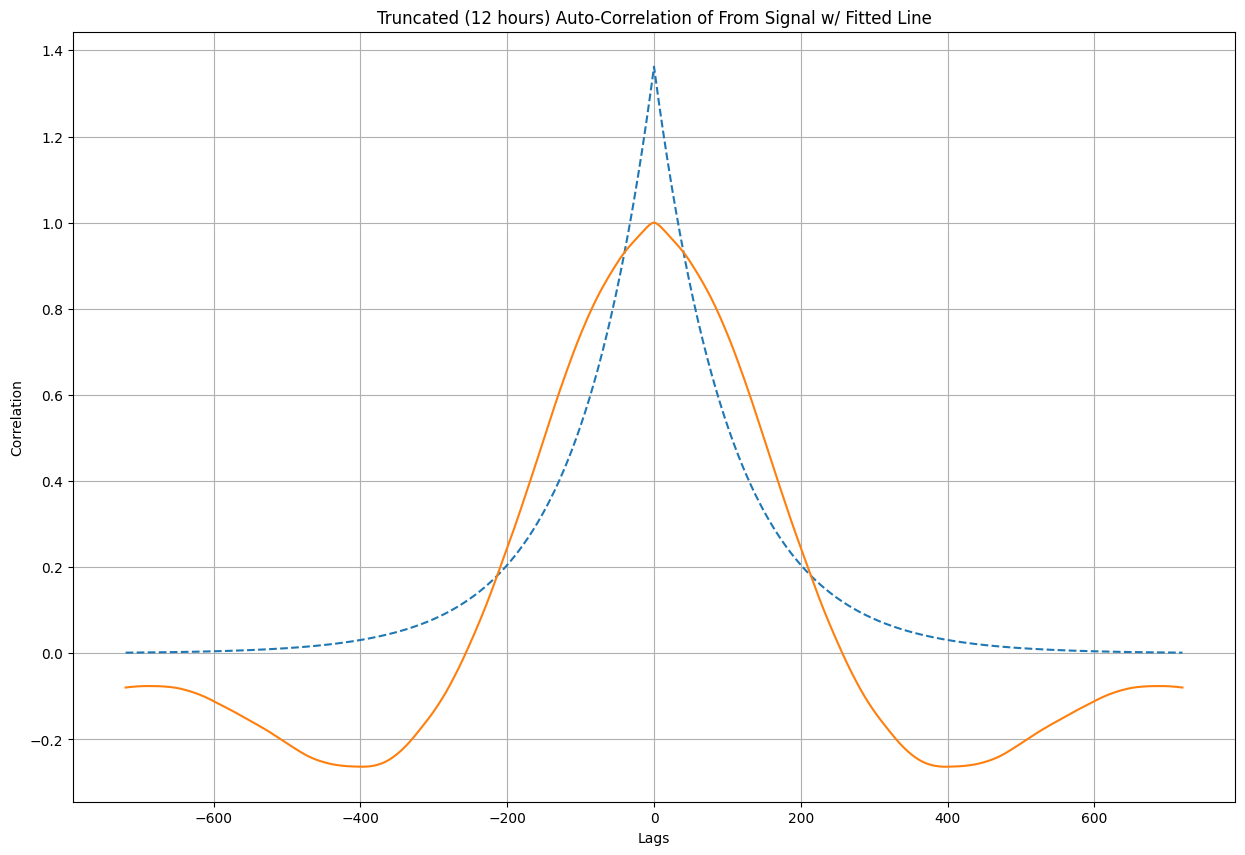

In [97]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

def monoExp(x, m, t):
    return m * np.exp(-t * np.abs(x))

# Greater than Zero
corr_from_trunc = np.hstack(np.array(corr_from_trunc))
lags_from_trunc = np.hstack(np.array(lags_from_trunc))
#print(corr_from_zero)

# perform the fit
params, cv = scipy.optimize.curve_fit(monoExp, lags_from_trunc, corr_from_trunc, maxfev =20000)
m, t = params

# determine quality of the fit
squaredDiffs = np.square(corr_from_trunc - monoExp(lags_from_trunc, m, t))
squaredDiffsFromMean = np.square(corr_from_trunc - np.mean(corr_from_trunc))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

plt.figure()
plt.plot(lags_from_trunc, monoExp(lags_from_trunc, m, t), '--', label="fitted")
plt.plot(lags_from_trunc, corr_from_trunc)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title(f'Truncated ({hours} hours) Auto-Correlation of From Signal w/ Fitted Line')
plt.grid()

# inspect the parameters
print(f"Y = {m} * e^(-{t}|x|)")

/tmp/ipykernel_4201/410865804.py:6: RuntimeWarning: overflow encountered in exp
  return m * np.exp(-t * np.abs(x))


R² = 0.7849751328363488
Y = 1.3531298420159588 * e^(-0.009979602250777334|x|)


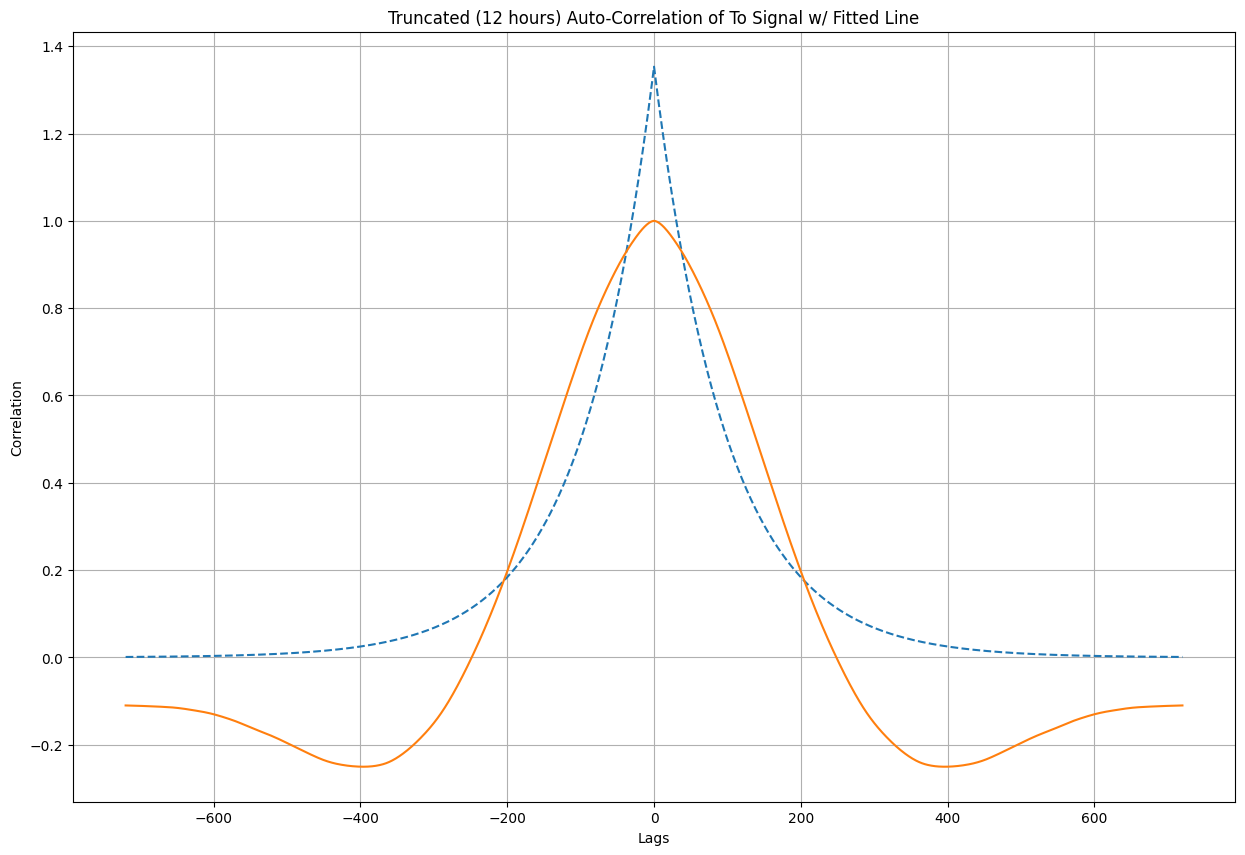

In [98]:
# Greater than Zero
corr_to_trunc = np.hstack(np.array(corr_to_trunc))
lags_to_trunc = np.hstack(np.array(lags_to_trunc))
#print(corr_from_zero)

# perform the fit
params, cv = scipy.optimize.curve_fit(monoExp, lags_to_trunc, corr_to_trunc, maxfev =20000)
m, t = params

# determine quality of the fit
squaredDiffs = np.square(corr_to_trunc - monoExp(lags_to_trunc, m, t))
squaredDiffsFromMean = np.square(corr_to_trunc - np.mean(corr_to_trunc))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

plt.figure()
plt.plot(lags_to_trunc, monoExp(lags_to_trunc, m, t), '--', label="fitted")
plt.plot(lags_to_trunc, corr_to_trunc)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title(f'Truncated ({hours} hours) Auto-Correlation of To Signal w/ Fitted Line')
plt.grid()

# inspect the parameters
print(f"Y = {m} * e^(-{t}|x|)")

In [ ]:
# Try Filtering Method 
corr_from = np.hstack(np.array(corr_from))
lags_from = np.hstack(np.array(lags_from))